# IMPORT

In [28]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.preprocessing.transforms import one_hot_encoder, one_hot_decoder, zscore
from deepmeg.data.datasets import EpochsDataset
import math


def accuracy(predictions, targets):

    # Convert one-hot encoded labels to class indices
    targets = torch.argmax(targets, dim=1)

    # Compute predicted class indices
    _, predicted = torch.max(predictions, dim=1)

    # Compute accuracy
    correct = torch.sum(predicted == targets)
    total = targets.shape[0]
    accuracy = correct / total

    return accuracy


# Encoder-Decoder LSTM with Bahdanau Attention

In [13]:
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_hidden_size: int, decoder_hidden_size: int, attention_size: int, bias: bool = True):
        """
        Bahdanau Attention Mechanism.

        Args:
            encoder_hidden_size (int): The size of the encoder hidden states.
            decoder_hidden_size (int): The size of the decoder hidden states.
            attention_size (int): The size of the attention vector.
        """
        super(BahdanauAttention, self).__init__()
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.attention_size = attention_size

        self.W_enc = nn.Linear(encoder_hidden_size, attention_size)
        self.W_dec = nn.Linear(decoder_hidden_size, attention_size)
        self.V = nn.Linear(attention_size, 1)

        if bias:
            self.bias = nn.Parameter(torch.empty(attention_size))
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_dec.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(self.bias, -bound, bound)
        else:
            self.register_parameter('bias', None)

    def forward(self, encoder_hidden_states: torch.Tensor, decoder_hidden_state: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Perform the forward pass of the Bahdanau Attention Mechanism.

        Args:
            encoder_hidden_states (torch.Tensor): The encoder hidden states. Shape: (batch_size, seq_length, encoder_hidden_size)
            decoder_hidden_state (torch.Tensor): The current decoder hidden state. Shape: (batch_size, decoder_hidden_size)

        Returns:
            context_vector (torch.Tensor): The context vector for the current decoder step. Shape: (batch_size, encoder_hidden_size)
            attention_weights (torch.Tensor): The attention weights over the encoder hidden states. Shape: (batch_size, seq_length)
        """
        seq_length = encoder_hidden_states.size(1)

        # Calculate alignment scores
        encoder_score = self.W_enc(encoder_hidden_states)  # (batch_size, seq_length, attention_size)

        decoder_score = self.W_dec(decoder_hidden_state)  # (batch_size, 1, attention_size)

        # Combine encoder and decoder scores and apply the non-linearity
        b = self.bias if self.bias is not None else 0
        alignment_scores = torch.tanh(encoder_score + torch.unsqueeze(decoder_score, 1) + b)  # (batch_size, seq_length, attention_size)

        # Calculate attention weights
        attention_weights = self.V(alignment_scores).squeeze(-1)  # (batch_size, seq_length)

        # Apply softmax to get normalized attention weights
        attention_weights = torch.softmax(attention_weights, dim=-1)  # (batch_size, seq_length)

        # Calculate context vector as a weighted sum of encoder hidden states
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_hidden_states.view(-1, seq_length, self.encoder_hidden_size))
        context_vector = context_vector.squeeze(1)  # (batch_size, encoder_hidden_size)

        return context_vector, attention_weights


class EncoderDecoderLSTM(nn.Module):
    def __init__(self, input_size: int, encoder_hidden_size: int, decoder_hidden_size: int, attention_size: int):
        """
        Encoder-Decoder LSTM with Bahdanau Attention.

        Args:
            input_size (int): The size of the input features.
            encoder_hidden_size (int): The size of the encoder hidden states.
            decoder_hidden_size (int): The size of the decoder hidden states.
            attention_size (int): The size of the attention vector.
        """
        super(EncoderDecoderLSTM, self).__init__()
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.attention_size = attention_size

        self.encoder_lstm = nn.LSTM(input_size, encoder_hidden_size, batch_first=True)
        self.attention = BahdanauAttention(encoder_hidden_size, decoder_hidden_size, attention_size)

        self.decoder_lstm = nn.LSTMCell(decoder_hidden_size + encoder_hidden_size, decoder_hidden_size)
        self._attention_weights = None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform the forward pass of the Encoder-Decoder LSTM.

        Args:
            x (torch.Tensor): The input tensor. Shape: (n_batch, n_times, n_features)

        Returns:
            output (torch.Tensor): The output tensor. Shape: (n_batch, n_times, decoder_hidden_size)
        """
        n_batch, n_times, n_features = x.size()

        # Encoder LSTM
        encoder_hidden_states, (h_n_enc, c_n_enc) = self.encoder_lstm(x)

        # Decoder LSTM initial hidden state
        h_n_dec, c_n_dec = self.decoder_lstm(torch.zeros(n_batch, self.decoder_hidden_size + self.encoder_hidden_size).to(x.device))

        # Output tensor to store predictions
        output = torch.zeros(n_batch, n_times, self.decoder_hidden_size).to(x.device)
        attention_weights = list()

        # Iterate over each time step
        for t in range(n_times):

            context_vector, current_attention_weights = self.attention(encoder_hidden_states, h_n_dec)

            attention_weights.append(current_attention_weights)

            # Concatenate the context vector with the current decoder hidden state
            decoder_input = torch.cat((context_vector, h_n_dec), dim=-1)

            # Update the decoder LSTM hidden state at the current time step
            h_n_dec, c_n_dec = self.decoder_lstm(decoder_input, (h_n_dec, c_n_dec))

            # Compute output at the current time step
            output[:, t, :] = h_n_dec

        self._attention_weights = attention_weights
        return output
        # return encoder_hidden_states

    @property
    def attention_weights(self):
        return self._attention_weights


In [14]:
m = EncoderDecoderLSTM(
    input_size=204,
    encoder_hidden_size=30,
    decoder_hidden_size=5,
    attention_size=10
)
x = torch.randn(10, 301, 204) # batch_size, seq_len, input_size
m(x)

tensor([[[-0.1041, -0.0164,  0.1089, -0.1242,  0.1519],
         [-0.1131, -0.0087,  0.1403, -0.1693,  0.1538],
         [-0.1129, -0.0033,  0.1596, -0.2002,  0.1536],
         ...,
         [-0.1028,  0.0060,  0.1903, -0.2664,  0.1563],
         [-0.1028,  0.0060,  0.1903, -0.2664,  0.1563],
         [-0.1028,  0.0060,  0.1903, -0.2664,  0.1563]],

        [[-0.1028, -0.0019,  0.1038, -0.1361,  0.1527],
         [-0.1123,  0.0133,  0.1335, -0.1867,  0.1557],
         [-0.1126,  0.0225,  0.1532, -0.2206,  0.1558],
         ...,
         [-0.1027,  0.0343,  0.1885, -0.2924,  0.1582],
         [-0.1027,  0.0343,  0.1885, -0.2924,  0.1582],
         [-0.1027,  0.0343,  0.1885, -0.2924,  0.1582]],

        [[-0.1171,  0.0021,  0.1046, -0.1417,  0.1630],
         [-0.1321,  0.0217,  0.1365, -0.1955,  0.1669],
         [-0.1342,  0.0336,  0.1578, -0.2305,  0.1667],
         ...,
         [-0.1248,  0.0467,  0.1959, -0.3003,  0.1683],
         [-0.1248,  0.0467,  0.1959, -0.3003,  0.1683],
  

## DATA

For testing

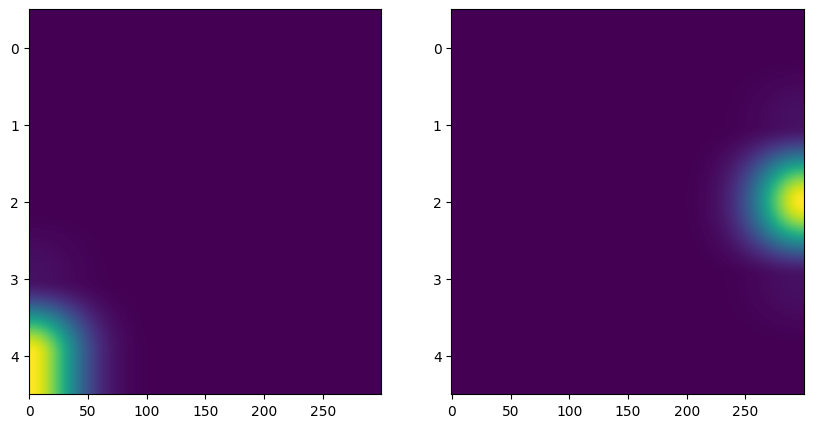

In [360]:
# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

x = np.linspace(-5, 5, 5)
y = np.linspace(-5, 5, 300)
x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
class_1_base = gaus2d(x, y, 5, -5, 1, 1)
class_1_base = (class_1_base - class_1_base.min())/(class_1_base.max() - class_1_base.min())
class_2_base = gaus2d(x, y, 0, 5, 1, 1)
class_2_base = (class_2_base - class_2_base.min())/(class_2_base.max() - class_2_base.min())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(class_1_base.T, aspect='auto')
ax2.imshow(class_2_base.T, aspect='auto')

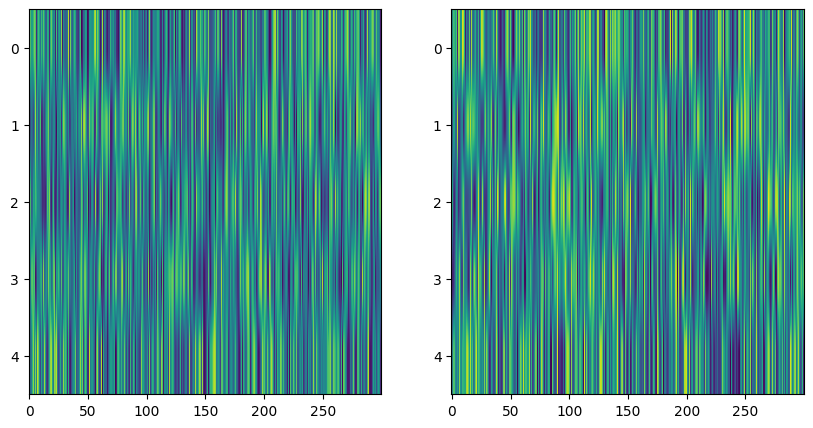

In [361]:
class_1_noise = np.random.random((1000, 300, 5))
class_2_noise = np.random.random((1000, 300, 5))
class_1_samples = class_1_base + 10*class_1_noise
class_2_samples = class_2_base + 10*class_2_noise

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(class_1_samples[0].T, aspect='auto')
ax2.imshow(class_2_samples[0].T, aspect='auto')

In [362]:
class_1_labels, class_2_labels = np.zeros((1000, )), np.ones((1000, ))

In [363]:
X = np.concatenate([class_1_samples, class_2_samples], axis=0)
Y = one_hot_encoder(np.concatenate([class_1_labels, class_2_labels], axis=0))

Text(0.5, 1.0, 'Class 1')

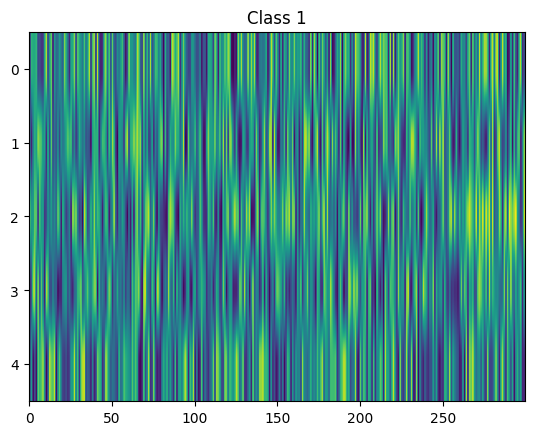

In [364]:
i = np.random.randint(0, len(Y))
plt.imshow(X[i].T, aspect='auto')
plt.title(f'Class {np.argmax(Y[i])}')

In [365]:
from deepmeg.data.datasets import EpochsDataset

dataset = EpochsDataset((X, Y), savepath='../datasets/5x300', transform = zscore)

In [366]:
dataset.save('../data/5x300.pt')

In [367]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

Text(0.5, 1.0, 'Class 1, -1.768 |  0.000 |  1.990')

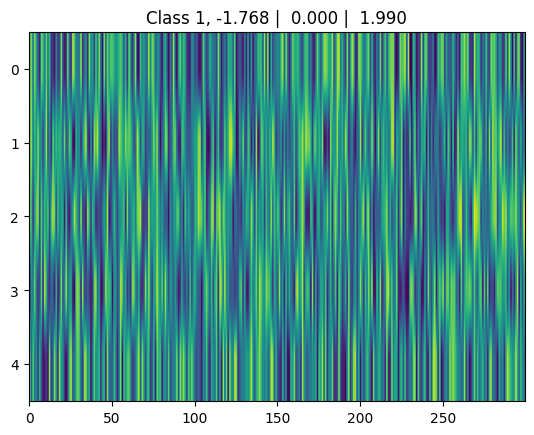

In [368]:
X, Y = next(iter(DataLoader(train)), 1)
plt.imshow(X[0].T, aspect='auto')
plt.title(f'Class {np.argmax(Y[0])}, {X.min() : .3f} | {X.mean() : .3f} | {X.max() : .3f}')

## Model

In [268]:
X, Y = next(iter(DataLoader(train, 2)))

In [269]:
X.shape

torch.Size([2, 300, 5])

In [270]:
dataset = EpochsDataset.load('../data/5x300.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [369]:
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg, PrintingCallback
from deepmeg.models import BaseModel
from deepmeg.utils.viz import plot_metrics


class TinyNet(BaseModel):

    def __init__(
        self,
        input_size: int,
        encoder_hidden_size: int,
        decoder_hidden_size: int,
        attention_size: int,
        n_times: int,
        n_outputs: int
    ):
        super().__init__()
        self.linear = nn.Linear(n_times, n_times//10)
        self.attn_net = EncoderDecoderLSTM(
            input_size=input_size,
            encoder_hidden_size=encoder_hidden_size,
            decoder_hidden_size=decoder_hidden_size,
            attention_size=attention_size
        )
        self.fc_layer = nn.Linear(decoder_hidden_size*n_times//10, n_outputs)


    def forward(self, x: torch.Tensor):
        x = torch.permute(x, (0, 2, 1))
        x = self.linear(x)
        x = torch.permute(x, (0, 2, 1))
        x = self.attn_net(x)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)


In [272]:
x = torch.rand(10, 300, 5)
model = TinyNet(5, 3, 3, 3, 300, 3)
model(x)

tensor([[-0.0177, -0.0265,  0.0469],
        [-0.0213, -0.0229,  0.0482],
        [-0.0194, -0.0249,  0.0472],
        [-0.0213, -0.0228,  0.0480],
        [-0.0196, -0.0247,  0.0476],
        [-0.0188, -0.0256,  0.0471],
        [-0.0175, -0.0266,  0.0468],
        [-0.0149, -0.0293,  0.0458],
        [-0.0160, -0.0281,  0.0463],
        [-0.0125, -0.0318,  0.0449]], grad_fn=<AddmmBackward0>)

In [370]:
config = dict(
    input_size=5,
    encoder_hidden_size=3,
    decoder_hidden_size=1,
    attention_size=3,
    n_times=300,
    n_outputs=2
)

In [274]:
config = dict(
    input_size=5,
    encoder_hidden_size=3,
    decoder_hidden_size=1,
    attention_size=3,
    n_times=100,
    n_outputs=2
)

In [8]:
config = dict(
    input_size=204,
    encoder_hidden_size=32,
    decoder_hidden_size=8,
    attention_size=16,
    n_times=301,
    n_outputs=8
)

In [374]:
dict(model.named_parameters()).keys()

dict_keys(['linear.weight', 'linear.bias', 'attn_net.encoder_lstm.weight_ih_l0', 'attn_net.encoder_lstm.weight_hh_l0', 'attn_net.encoder_lstm.bias_ih_l0', 'attn_net.encoder_lstm.bias_hh_l0', 'attn_net.attention.bias', 'attn_net.attention.W_enc.weight', 'attn_net.attention.W_enc.bias', 'attn_net.attention.W_dec.weight', 'attn_net.attention.W_dec.bias', 'attn_net.attention.V.weight', 'attn_net.attention.V.bias', 'attn_net.decoder_lstm.weight_ih', 'attn_net.decoder_lstm.weight_hh', 'attn_net.decoder_lstm.bias_ih', 'attn_net.decoder_lstm.bias_hh', 'fc_layer.weight', 'fc_layer.bias'])

In [381]:
model = TinyNet(
    **config
)

optimizer = torch.optim.AdamW

loss = torch.nn.BCEWithLogitsLoss()
# loss = nn.CrossEntropyLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', patience=30, restore_best_weights=False),
        # L2Reg('linear.weight', .001)
    ]
)

In [382]:
import sys

if hasattr(sys.stdout, 'file'):
  sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.6928   |    accuracy_train:  0.5167   |    loss_val:  0.6973   |    accuracy_val:  0.4558
Epoch 1:  loss_train:  0.6926   |    accuracy_train:  0.5167   |    loss_val:  0.6970   |    accuracy_val:  0.4558
Epoch 2:  loss_train:  0.6925   |    accuracy_train:  0.5167   |    loss_val:  0.6967   |    accuracy_val:  0.4558
Epoch 3:  loss_train:  0.6923   |    accuracy_train:  0.5167   |    loss_val:  0.6962   |    accuracy_val:  0.4558
Epoch 4:  loss_train:  0.6919   |    accuracy_train:  0.5167   |    loss_val:  0.6955   |    accuracy_val:  0.4558
Epoch 5:  loss_train:  0.6912   |    accuracy_train:  0.5167   |    loss_val:  0.6944   |    accuracy_val:  0.4558
Epoch 6:  loss_train:  0.6901   |    accuracy_train:  0.5167   |    loss_val:  0.6929   |    accuracy_val:  0.4558
Epoch 7:  loss_train:  0.6883   |    accuracy_train:  0.5437   |    loss_val:  0.6908   |    accuracy_val:  0.5331
Epoch 8:  loss_train:  0.6857   |    accuracy_train:  0.6909   |    loss_val:  0

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

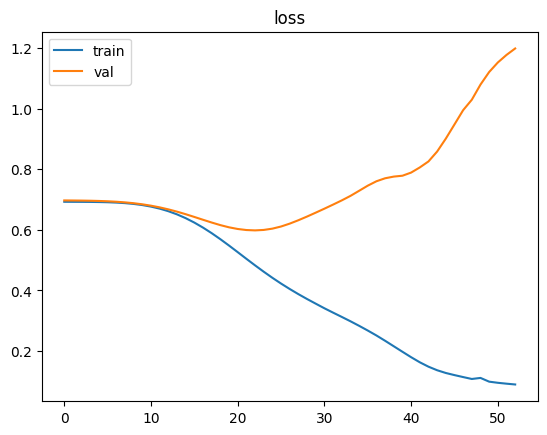

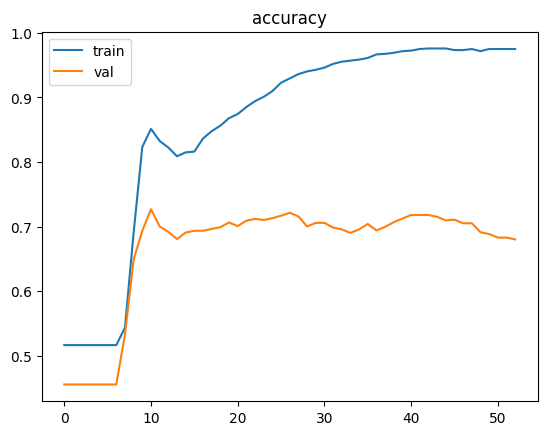

In [383]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [384]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.3343136005103588
train_accuracy: 0.9078571319580078
loss: 1.020771798491478
accuracy: 0.7400000035762787


In [341]:
X_test, Y_test = next(iter(DataLoader(test, len(test))))

Preds_test = model(X_test)

Text(0.5, 1.0, 'sample 396, class 1')

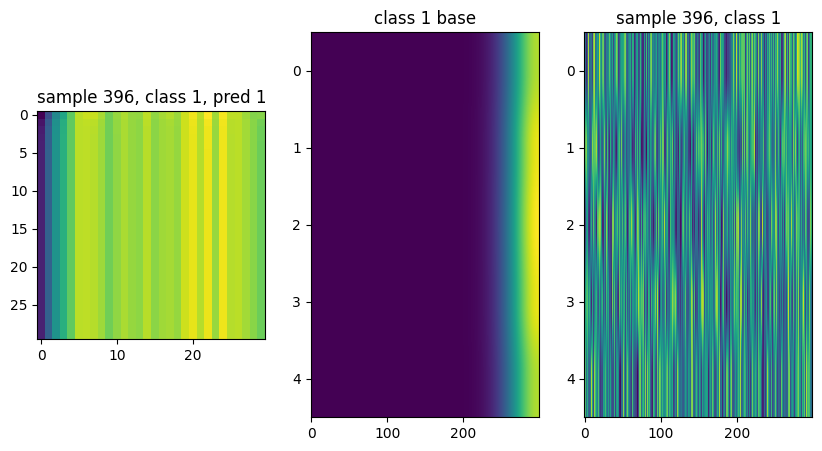

In [359]:
n = np.random.randint(0, len(test))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.imshow(torch.stack(model.attn_net.attention_weights)[:, n].detach().numpy())
label = np.argmax(Y_test[n]).item()
ax1.set_title(f'sample {n}, class {label}, pred {np.argmax(Preds_test[n].detach())}')

base = class_1_base if label == 0 else class_2_base

ax2.imshow(base.T, aspect='auto')
ax2.set_title(f'class {label} base')
ax3.imshow(X_test[n].T, aspect='auto')
ax3.set_title(f'sample {n}, class {label}')